In [3]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from evaluation.metrics import *

In [4]:
plot_path = "../../plots/"

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

In [6]:
ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 2.5

In [40]:
## Coordinates
lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)

# Original data

In [3]:
path = "../../data/application/"
file = xr.open_dataset(path + "1931_2020_raw.nc")

In [131]:
file = xr.open_dataset(path + "2021_raw.nc")
data = file.pr.sel(time = "2021-07").max(dim = "time", skipna = True)

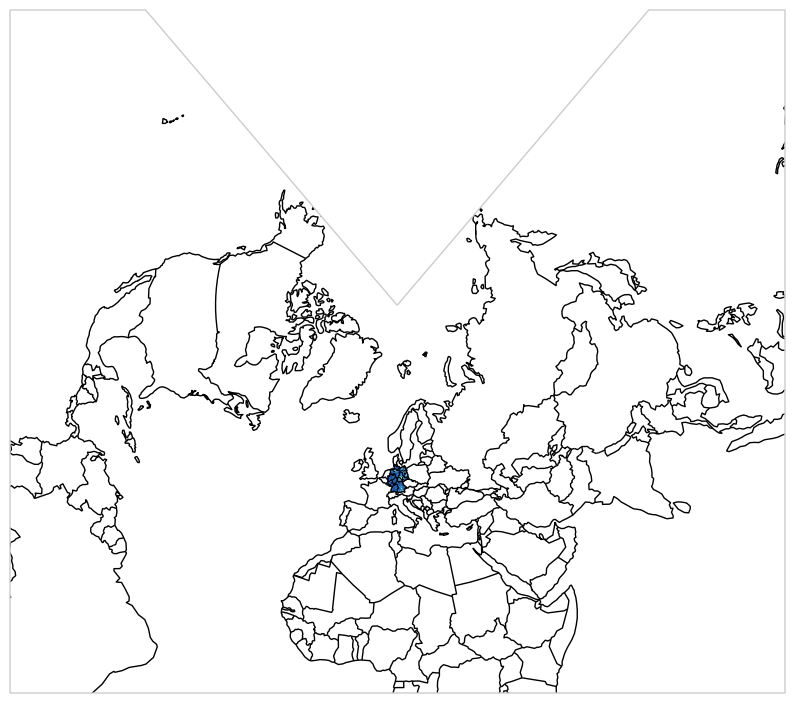

In [8]:

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=52,
                                                                        standard_parallels=(35,65), false_easting=4000000,
                                                                        false_northing=2800000)},figsize=(10,18))
axs.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                 edgecolor='black', facecolor = "None", lw = 0.3)

pcm = axs.pcolormesh(data.x, data.y, data)


(47.2, 55.2)

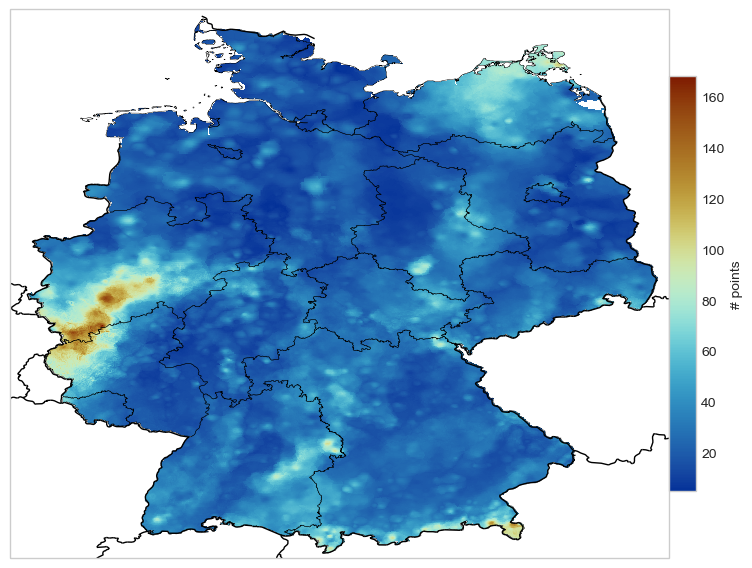

In [144]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,18))

axs.set_extent([lons[0],lons[1],lats[0],lats[1]])


ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                  edgecolor='black', facecolor = "None", lw = 0.3)
axs.add_feature(cfeature.BORDERS)
#axs.coastlines(resolution='10m')


pcm = axs.pcolormesh(data.lon, data.lat, data, transform = ccrs.PlateCarree())
fig.colorbar(pcm, ax=axs, label="# points", pad=0, shrink = 0.3, aspect = 15)


axs.set_xlim([5.6,15.2])
axs.set_ylim([47.2,55.2])

# Processed data

In [38]:
def plot_cities(axs):
    axs.plot(7.10066, 50.735851, ".", color = "black", markersize=15)
    axs.text(7.12, 50.735851, 'Bonn', fontsize = 20)

    axs.plot(6.959974, 50.938361, ".", color = "black", markersize=15)
    axs.text(6.985, 50.938361, 'Köln', fontsize = 20)

    axs.plot(6.486739, 50.799552, ".", color = "black", markersize=15)
    axs.text(6.50, 50.799552, 'Düren', fontsize = 20)

In [7]:
path = "../../data/application/"
year = "2023"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

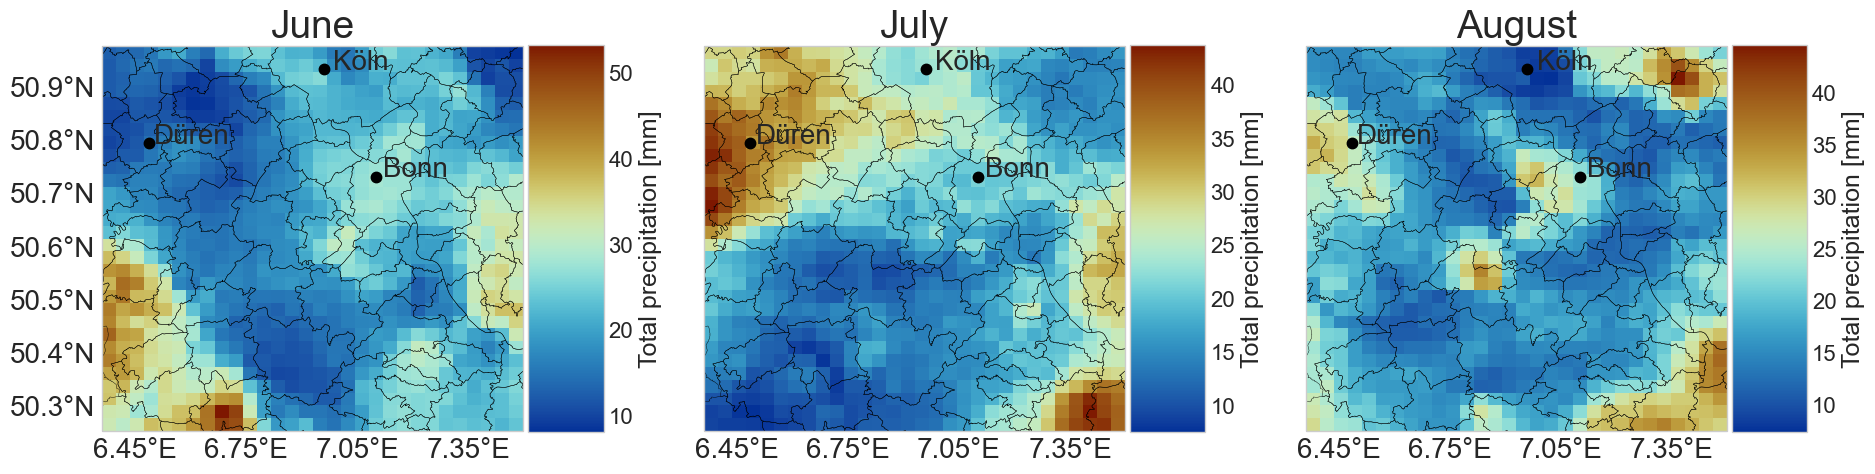

In [9]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data.isel(time = i))
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")



plt.savefig(plot_path + f"{year}_tp.png", bbox_inches = "tight")

# Data with Fréchet margins

In [8]:

gev_params = {
    "loc1": 64.799623725,
    "loc_lat": -0.999680643,
    "loc_lon": 0.014852714,
    "loc_time": 0.001105532,
    "scale": 7.004518221,
    "shape": 0.105249698,
}


In [23]:
path = "../data/application/data/"
year = "2023"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

In [10]:
def gev2frech(data, year):
    # Define lat lon grid
    lons = np.linspace(6.38, 7.48, 30)
    lats = np.linspace(50.27, 50.97, 30)
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Define year
    year_emb = year - 1931 + 1

    # Calculate parameters
    mu = (
        gev_params["loc1"]
        + lat2d * gev_params["loc_lat"]
        + lat2d * gev_params["loc_lon"]
        + year_emb * gev_params["loc_time"]
    )
    sigma = gev_params["scale"]
    gamma = gev_params["shape"]

    # Transformation
    result = np.power(1 + gamma * (data - mu) / sigma, (1 / gamma))

    return result


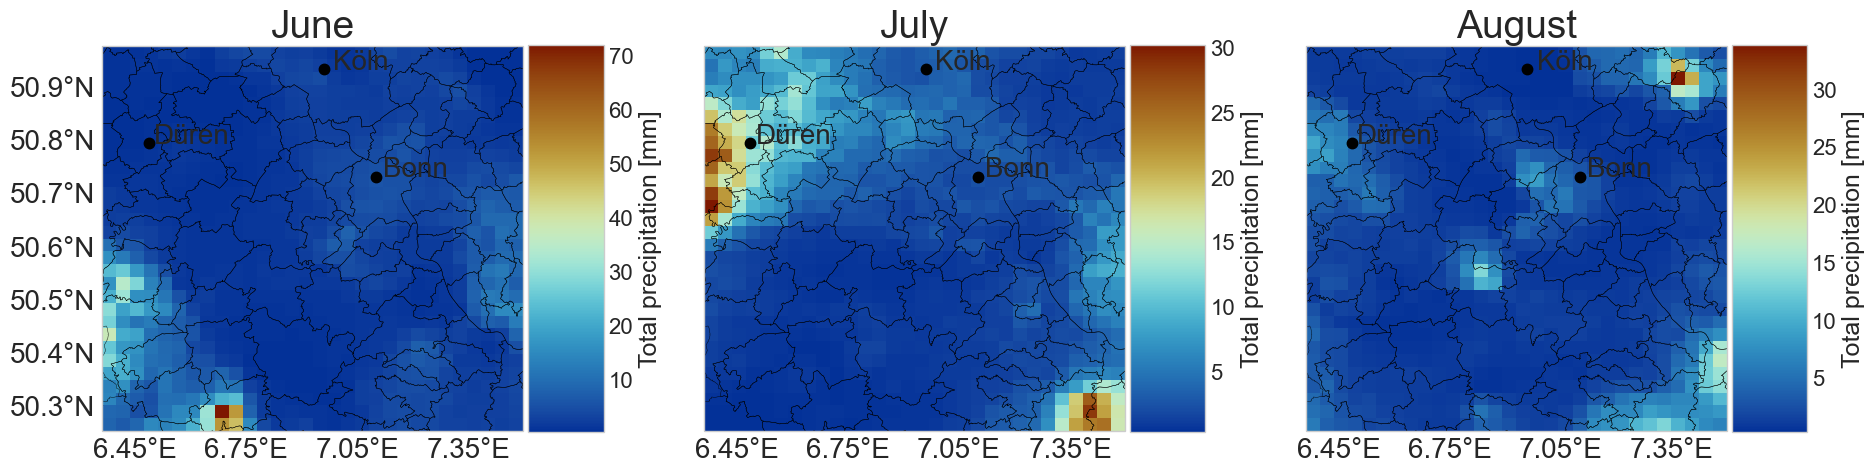

In [13]:
# Transformation
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    data_transformed = gev2frech(data.isel(time = i), year = 2022)
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data_transformed)
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")

plt.savefig(plot_path + f"{year}_frechet_tp.png", bbox_inches = "tight")


# Results

In [17]:
model = "powexp"
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

In [18]:
plt.style.use('seaborn-v0_8')
colors = [cmap(x) for x in np.linspace(0.1,0.99,6)]
labels = ["June 2021", "July 2021", "August 2021", "June 2022", "July 2022", "August 2022", "June 2023", "July 2023", "August 2023"]

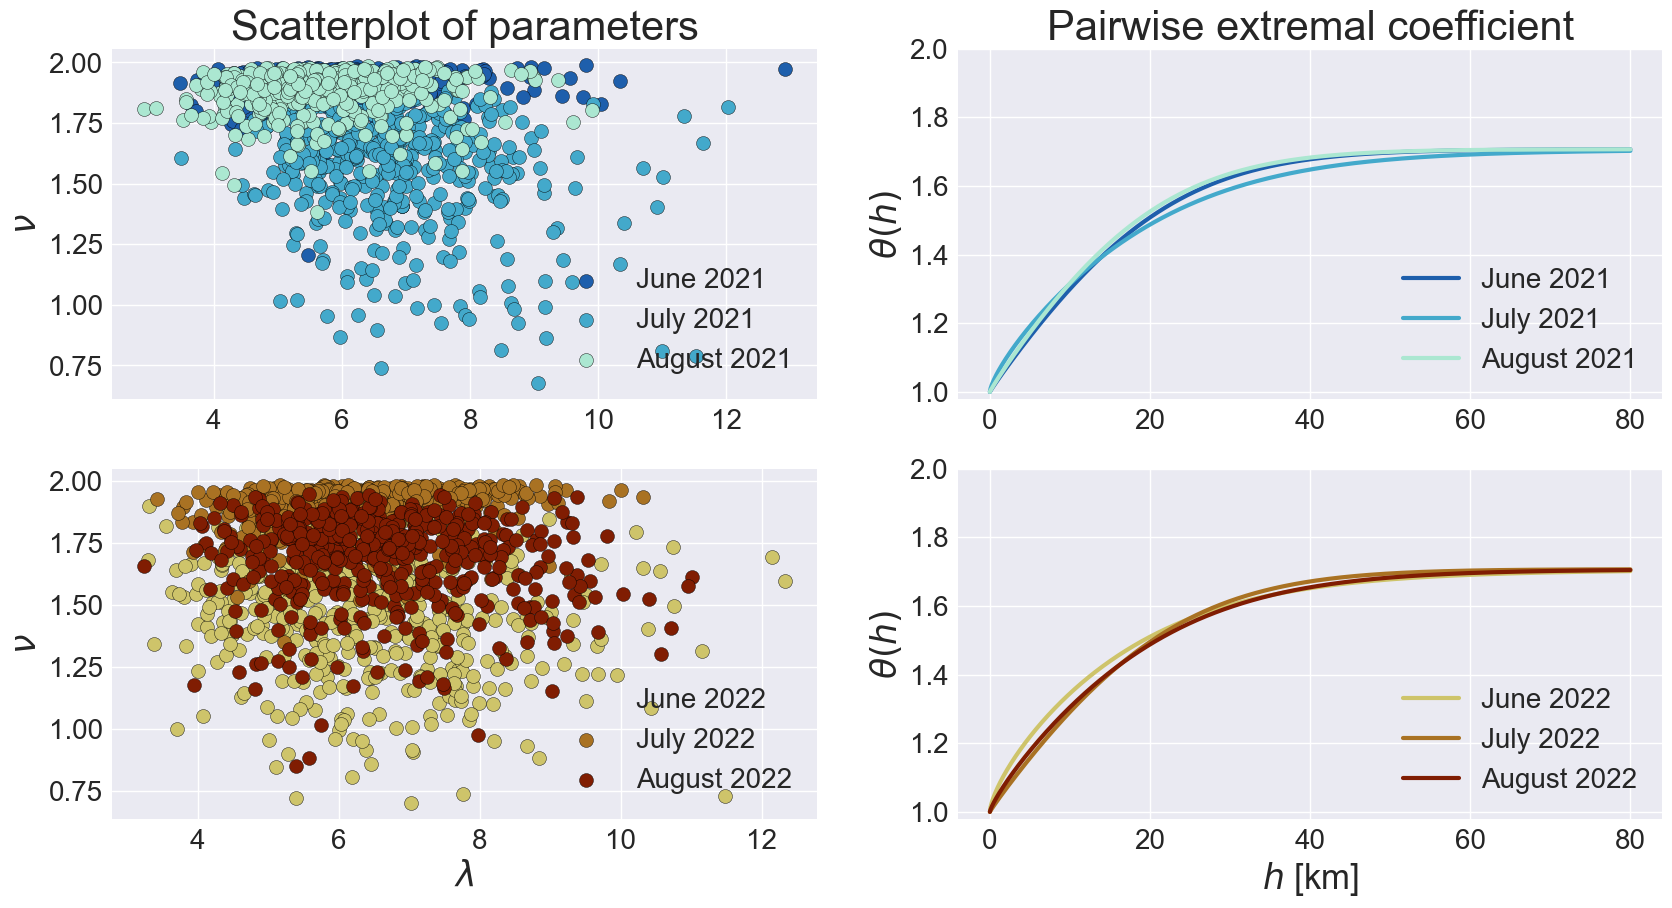

In [19]:
h = np.linspace(0,20,1000)
h_plot = h *4

fig, axs = plt.subplots(2,2, figsize = (20,10))
axs = np.transpose(axs).ravel()

for i in range(3):
    #Mean values
    axs[0].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i])
    #axs[0].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[0].set_ylabel(r"$\nu$", fontsize = axsize)
    axs[0].tick_params(axis='both', labelsize=ticksize)
   # axs[0].set_xlim([1.5,9])
   # axs[0].set_ylim([0.8,2])
    axs[0].legend(fontsize = legendsize)
    axs[0].set_title("Scatterplot of parameters", fontsize = titlesize)

for i in range(3,6):
    #Mean values
    axs[1].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i])
    axs[1].set_xlabel(r"$\lambda$", fontsize = axsize)
    axs[1].set_ylabel(r"$\nu$", fontsize = axsize)
    axs[1].tick_params(axis='both', labelsize=ticksize)
   #axs[1].set_xlim([1.5,9])
   # axs[1].set_ylim([0.8,2])
    axs[1].legend(fontsize = legendsize)
    #axs[1].set_title("2022")



for i in range(3):
    axs[2].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    #axs[2].set_xlabel(r"$h$", fontsize = 15)
    axs[2].set_ylabel(r"$\theta(h)$", fontsize = axsize)
    axs[2].tick_params(axis='both', labelsize=ticksize)
    axs[2].legend(fontsize = legendsize)
    axs[2].set_title("Pairwise extremal coefficient", fontsize = titlesize)
    axs[2].set_ylim([0.98,2])

for i in range(3,6):
    axs[3].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    axs[3].set_xlabel("$h$ [km]", fontsize = axsize)
    axs[3].set_ylabel(r"$\theta(h)$", fontsize = axsize)
    axs[3].tick_params(axis='both', labelsize=ticksize)
    axs[3].legend(fontsize = legendsize)
    axs[3].set_ylim([0.98,2])

    #plt.savefig(plot_path + f"cnn_es_estimate.png", bbox_inches = "tight")

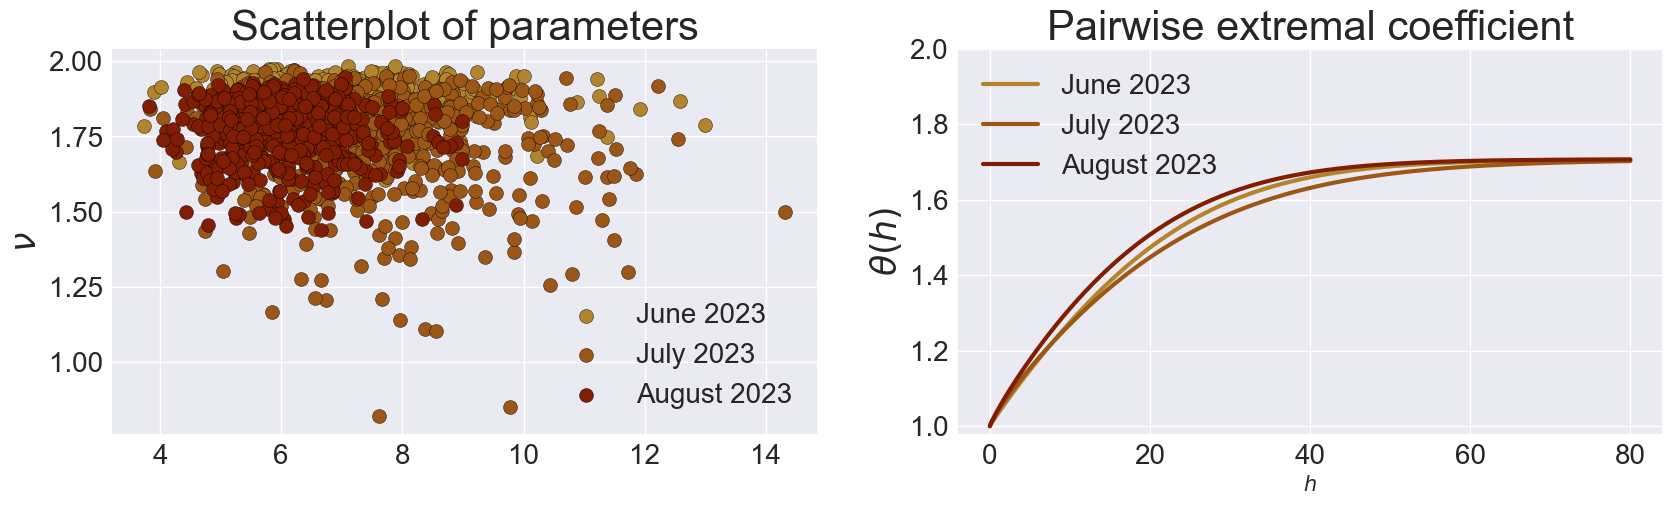

In [20]:
h = np.linspace(0,20,1000)
h_plot = h *4
colors = [cmap(x) for x in np.linspace(0.1,0.99,9)]

fig, axs = plt.subplots(1,2, figsize = (20,5))

for i in range(6,9):
    #Mean values
    axs[0].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i])
    #axs[0].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[0].set_ylabel(r"$\nu$", fontsize = axsize)
    axs[0].tick_params(axis='both', labelsize=ticksize)
    #axs[0].set_xlim([1.5,9])
    #axs[0].set_ylim([0.8,2])
    axs[0].legend(fontsize = legendsize)
    axs[0].set_title("Scatterplot of parameters", fontsize = titlesize)

for i in range(6,9):
    axs[1].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    axs[1].set_xlabel(r"$h$", fontsize = 15)
    axs[1].set_ylabel(r"$\theta(h)$", fontsize = axsize)
    axs[1].tick_params(axis='both', labelsize=ticksize)
    axs[1].legend(fontsize = legendsize)
    axs[1].set_title("Pairwise extremal coefficient", fontsize = titlesize)
    axs[1].set_ylim([0.98,2])

# Distance plot

In [72]:
model = "brown"
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

In [73]:
path = "../../data/application/"
grid = xr.open_dataset(path + "grid.nc").grid.data

In [78]:
point = 589
transformed_grid = np.sqrt(np.sum(np.power(grid - grid[:,point:(point+1)],2), axis = 0)).reshape((30,30))
i = 1
ext = sample_extremal_coefficient(transformed_grid, model, cnn_es[i,0], cnn_es[i,1])

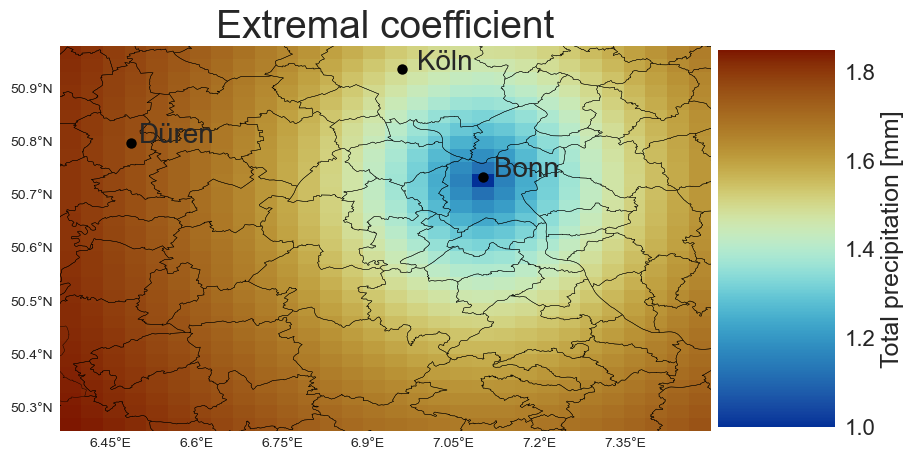

In [79]:
# Transformation
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,5))


ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                edgecolor='black', facecolor = "None", lw = 0.3)
pcm = axs.pcolormesh(lons, lats, ext, cmap = cmap)
cb = fig.colorbar(pcm, ax=axs,  pad = 0.01, shrink = 4, aspect = 3.24)
cb.set_label(label="Total precipitation [mm]",size=18)
cb.ax.tick_params(labelsize=16)
plot_cities(axs)
axs.set_title(f"Extremal coefficient", fontsize = fontsize)
gl = axs.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

axs.set_aspect("auto")